In [ ]:
import h5py as h5
import netCDF4 as nc
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import time
import cv2
import csv
from global_land_mask import globe
import glob
import math
from tqdm import tqdm
import re
import seaborn as sns


land_mask.shape: (8000, 10500)
Unique values in land_mask: [0. 1.]


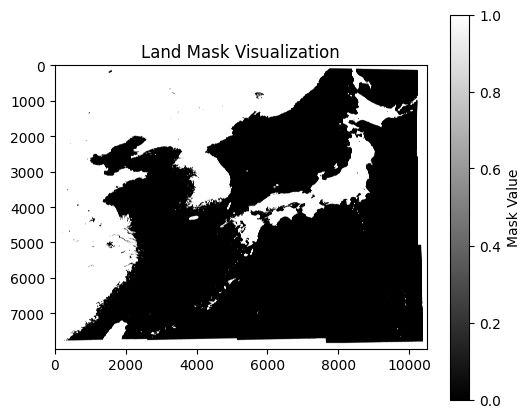

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io

# MATLAB 파일 로드
mat_file = io.loadmat('/home/juneyonglee/Desktop/AY_ust/preprocessing/Land_mask/Land_mask.mat')
land_mask = mat_file['Land']

# shape 확인
print("land_mask.shape:", land_mask.shape)

# 고유값(unique) 확인
unique_vals = np.unique(land_mask)
print("Unique values in land_mask:", unique_vals)

# 시각화
plt.figure(figsize=(6, 5))
plt.imshow(land_mask, cmap='gray')
plt.colorbar(label='Mask Value')
plt.title('Land Mask Visualization')
plt.show()


In [2]:
import netCDF4 as nc

# 파일 경로
file_path = '/media/juneyonglee/My Book/UST21/01_day/2020/12/KHOA_Chla_L3_Z001_D01_WGS250M_U20201201.nc'

# NetCDF 파일 열기
dataset = nc.Dataset(file_path, 'r')

# 파일 키(변수, 차원, 속성) 확인
print("### Global Attributes ###")
for attr in dataset.ncattrs():
    print(f"{attr}: {getattr(dataset, attr)}")

print("\n### Dimensions ###")
for dim in dataset.dimensions.values():
    print(f"{dim.name}: {dim.size}")

print("\n### Variables ###")
for var in dataset.variables.values():
    print(f"{var.name}: {var.dimensions}, {var.dtype}")

# 각 변수의 독립적인 값 확인 (첫 번째 몇 개 값만 출력)
print("\n### Sample Data from Variables ###")
for var_name, var in dataset.variables.items():
    try:
        print(f"{var_name}: {var[:5]}")  # 첫 5개의 값만 출력
    except Exception as e:
        print(f"{var_name}: Unable to preview data - {e}")

# 파일 닫기
dataset.close()


### Global Attributes ###
platform: GK-2B, Aqua, Suomi-NPP, Sentinel-3A/B
instrument: GOCI-II, MODIS, VIIRS, OLCI
reference_ellipsoid_name: WGS84
geographic_crs_name: WGS84, EPSG:4326
horizontal_datum_name: WGS84
Time_Standard: UTC
image_upperleft_latitude: 23.1700496673584
image_lowerright_latitude: 49.157859802246094
image_upperleft_longitude: 150.8547821044922
image_lowerright_longitude: 111.60403442382812
geospatial_lat_units: degree
geospatial_lon_units: degree
input_slots: 0,1,2,3,4,5,6,7,8,9,10,11
number_of_total_slots: 12
dataset_area: Z001
source: GOCI-II_L2_AC, MODIS_L2_OC, MODIS_L2_IOP, VIIRS_L2_OC, VIIRS_L2_IOP, OLCI_L2_OC, OLCI_L2_IOP
algorithm: merged_daily_Chl
algorithm_version: 1.0
spatial_resolution: 0.03
geospatial_lat_resolution: 0.03
geospatial_lon_resolution: 0.03
temporal_resolution: 1
spatial_resolution_unit: degree
temporal_resolution_unit: day
number_of_pixel: 8,000*10,500
time_coverage_start: 202012010100
time_coverage_end: 202012010500
product_name: 엽록소 농도, C

In [3]:
import netCDF4 as nc
import numpy as np

# 파일 경로
file_path = '/media/juneyonglee/My Book/UST21/01_day/2020/12/KHOA_Chla_L3_Z001_D01_WGS250M_U20201201.nc'

# NetCDF 파일 열기
dataset = nc.Dataset(file_path, 'r')

# 특정 변수 선택 (예: merged_daily_Chl)
variable_name = 'merged_daily_Chl'  # 변수 이름을 실제 이름으로 교체
var_data = dataset.variables[variable_name][:]

# NaN이 아닌 고유한 값 확인
unique_values = np.unique(var_data[~np.isnan(var_data)])

print(f"### Unique Non-NaN Values in '{variable_name}' ###")
print(unique_values)

# 고유 값의 개수 확인
print(f"\nTotal unique non-NaN values: {len(unique_values)}")

# 파일 닫기
dataset.close()


### Unique Non-NaN Values in 'merged_daily_Chl' ###
[ 0.01        0.01000005  0.01000009 ...  9.999397    9.999493
 10.        ]

Total unique non-NaN values: 6134254


In [5]:
import netCDF4 as nc
import numpy as np

# 파일 경로
input_file = '/media/juneyonglee/My Book/UST21/01_day/2020/12/KHOA_Chla_L3_Z001_D01_WGS250M_U20201201.nc'
output_mask_file = 'land_sea_mask.npy'  # 저장할 마스크 파일 경로

# NetCDF 파일 열기
dataset = nc.Dataset(input_file, 'r')

# 변수 선택 (예: merged_daily_Chl)
variable_name = 'merged_daily_Chl'  # 변수 이름을 실제 이름으로 교체
var_data = dataset.variables[variable_name][:]

# NaN -> 육지(0), 값이 있는 부분 -> 해양(1)
land_sea_mask = np.where(np.isnan(var_data), 0, 1)

# 마스크 저장
np.save(output_mask_file, land_sea_mask)

# 확인
print(f"Land-sea mask saved as '{output_mask_file}'")
print(f"Mask shape: {land_sea_mask.shape}")
print(f"Land (0) count: {np.sum(land_sea_mask == 0)}")
print(f"Sea (1) count: {np.sum(land_sea_mask == 1)}")

# NetCDF 파일 닫기
dataset.close()


Land-sea mask saved as 'land_sea_mask.npy'
Mask shape: (8000, 10500)
Land (0) count: 77227654
Sea (1) count: 6772346


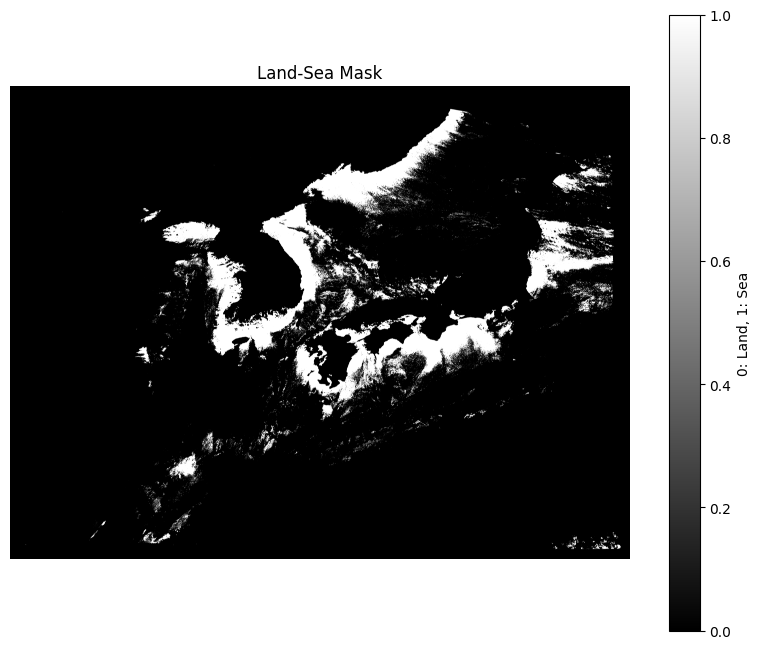

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 마스크 파일 경로
mask_file = '/home/juneyonglee/Desktop/AY_ust/Notebook/land_sea_mask.npy'

# 마스크 파일 불러오기
land_sea_mask = np.load(mask_file)

# 마스크 시각화
plt.figure(figsize=(10, 8))
plt.imshow(land_sea_mask, cmap='gray')
plt.title('Land-Sea Mask')
plt.colorbar(label='0: Land, 1: Sea')
plt.axis('off')
plt.show()


2025-01-21 22:48:04,944 - INFO - Band 2 data loaded successfully.
2025-01-21 22:48:05,046 - INFO - Band 2 - Min: -999.0, Max: 0.0978151261806488, Mean: -823.8126831054688, Std: 379.9016418457031
/tmp/ipykernel_1600170/568768037.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet').copy()


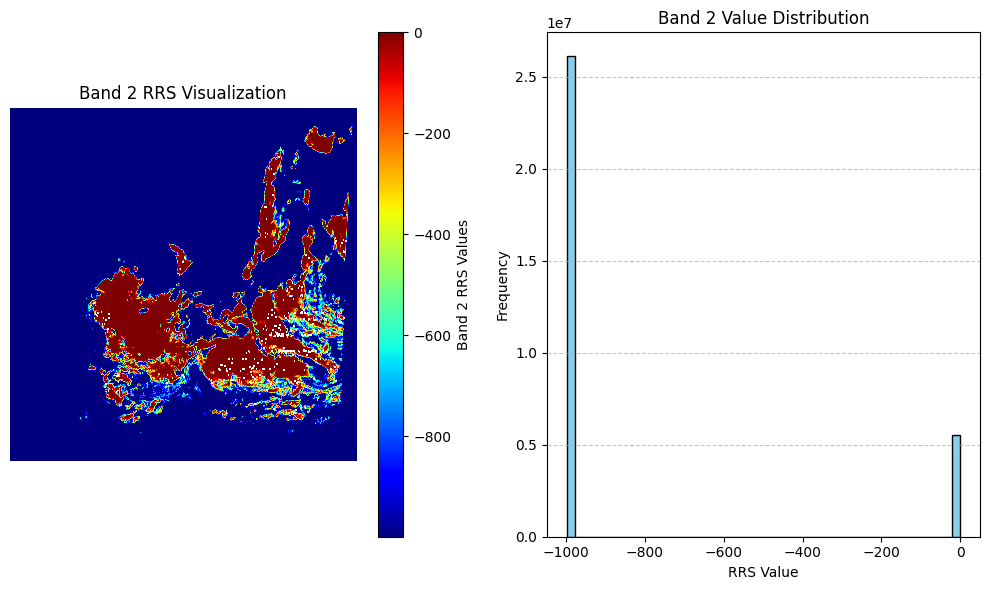

Band 2 Statistics:
  Min Value: -999.0
  Max Value: 0.0978151261806488
  Mean Value: -823.8126831054688
  Std Dev: 379.9016418457031



2025-01-21 22:48:07,305 - INFO - Band 3 data loaded successfully.
2025-01-21 22:48:07,417 - INFO - Band 3 - Min: -999.0, Max: 0.07153353840112686, Mean: -823.8110961914062, Std: 379.9034729003906


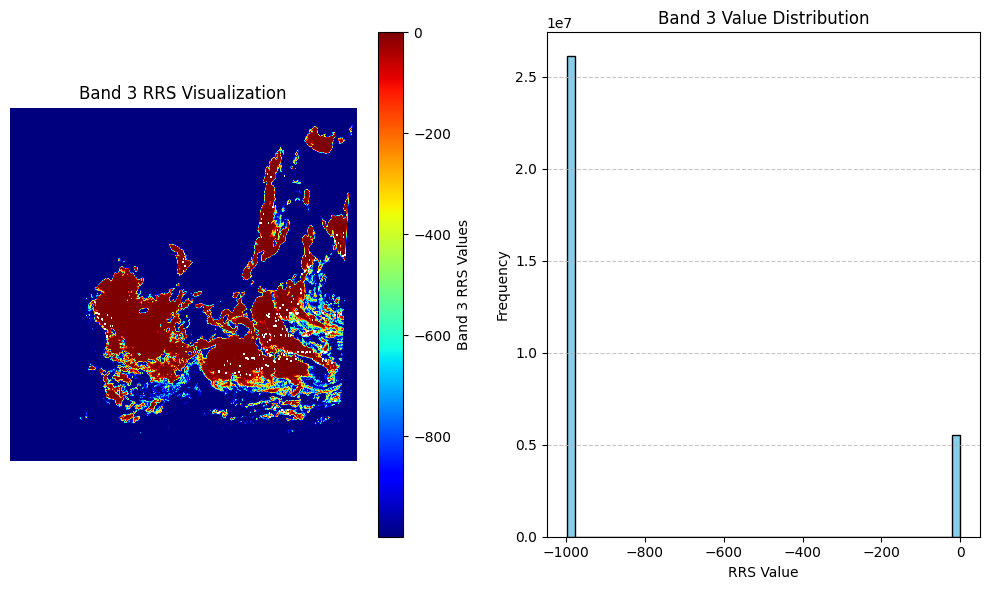

Band 3 Statistics:
  Min Value: -999.0
  Max Value: 0.07153353840112686
  Mean Value: -823.8110961914062
  Std Dev: 379.9034729003906



2025-01-21 22:48:09,527 - INFO - Band 4 data loaded successfully.
2025-01-21 22:48:09,625 - INFO - Band 4 - Min: -999.0, Max: 0.059344466775655746, Mean: -823.8077392578125, Std: 379.90728759765625


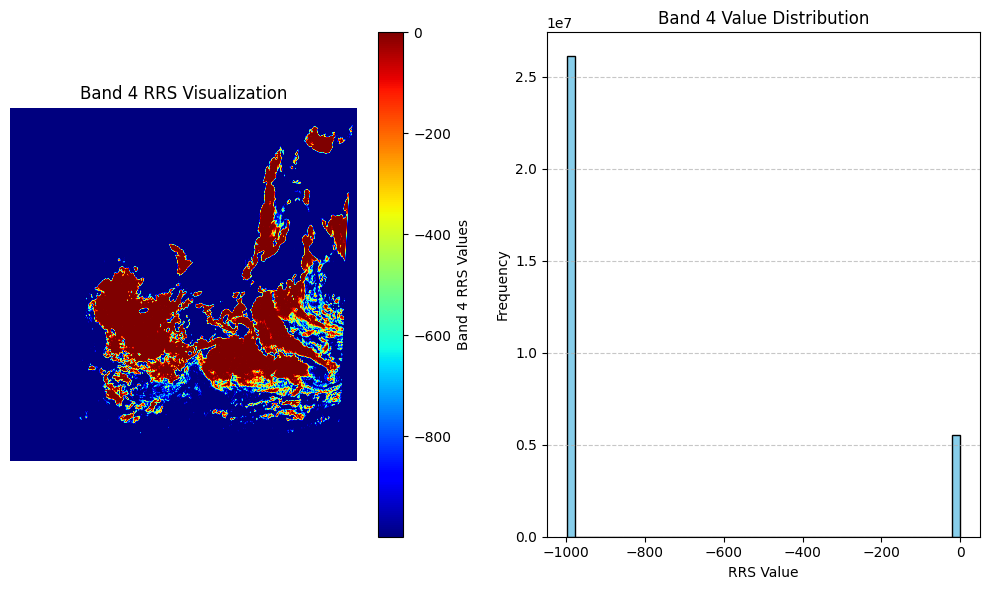

Band 4 Statistics:
  Min Value: -999.0
  Max Value: 0.059344466775655746
  Mean Value: -823.8077392578125
  Std Dev: 379.90728759765625



In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import logging

# 파일 경로 지정
file_path = '/home/juneyonglee/Documents/RRS/COMS_GOCI_L2A_GA_20110401001641.RRS.he5'
bands = [2, 3, 4]  # 사용할 밴드 리스트

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 데이터를 읽는 함수
def read_band_data(file_path, band):
    try:
        with nc.Dataset(file_path, 'r') as f:
            var_name = f'HDFEOS/GRIDS/Image Data/Data Fields/Band {band} RRS Image Pixel Values'
            rrs_data = f[var_name][:]
            rrs_data = np.where(rrs_data == -999.0, np.nan, rrs_data)  # NaN으로 유효하지 않은 값 처리
            logging.info(f"Band {band} data loaded successfully.")
            return rrs_data
    except Exception as e:
        logging.error(f"Error loading Band {band} data: {e}")
        return None

# 데이터 통계 및 시각화
def visualize_and_analyze(rrs_data, band):
    if rrs_data is None:
        logging.warning(f"Skipping Band {band} due to missing data.")
        return

    # 통계 정보 계산
    valid_data = rrs_data[~np.isnan(rrs_data)]  # NaN 제외
    min_val, max_val, mean_val, std_val = np.min(valid_data), np.max(valid_data), np.mean(valid_data), np.std(valid_data)
    logging.info(f"Band {band} - Min: {min_val}, Max: {max_val}, Mean: {mean_val}, Std: {std_val}")

    # 시각화
    plt.figure(figsize=(10, 6))

    # 이미지 시각화
    plt.subplot(1, 2, 1)
    cmap = plt.cm.get_cmap('jet').copy()
    cmap.set_bad(color='white')  # NaN 값을 흰색으로 설정
    plt.imshow(rrs_data, cmap=cmap)
    plt.colorbar(label=f'Band {band} RRS Values')
    plt.title(f'Band {band} RRS Visualization')
    plt.axis('off')

    # 히스토그램 시각화
    plt.subplot(1, 2, 2)
    bins = np.linspace(min_val, max_val, 50)
    plt.hist(valid_data, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Band {band} Value Distribution')
    plt.xlabel('RRS Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 통계 정보 출력
    print(f"Band {band} Statistics:")
    print(f"  Min Value: {min_val}")
    print(f"  Max Value: {max_val}")
    print(f"  Mean Value: {mean_val}")
    print(f"  Std Dev: {std_val}\n")

# 각 밴드 데이터 처리
for band in bands:
    rrs_data = read_band_data(file_path, band)
    visualize_and_analyze(rrs_data, band)


In [32]:
# import os
# from PIL import Image

# def remove_error_files(file_paths):
#     for file_path in file_paths:
#         try:
#             # 이미지 열어보기 시도
#             with Image.open(file_path) as img:
#                 img.verify()  # 이미지 파일이 유효한지 확인
#         except Exception as e:
#             # 파일 열기에 실패하면 파일 삭제
#             print(f"Removing error file: {file_path}")
#             try:
#                 os.remove(file_path)
#             except Exception as remove_error:
#                 print(f"Failed to remove {file_path}: {str(remove_error)}")

# # 파일 경로 리스트 예시 (newtrain 경로 내의 모든 .tiff 파일을 검색)
# directory = "/media/juneyonglee/My Book/Preprocessed/GOCI/L2_Rrs_newtrain/band_2"
# file_paths = []

# # 디렉토리 내 모든 .tiff 파일 경로 추가
# for root, dirs, files in os.walk(directory):
#     for file in files:
#         if file.endswith(".tiff"):
#             file_paths.append(os.path.join(root, file))

# # 에러 발생 파일 삭제
# remove_error_files(file_paths)


Removing error file: /media/juneyonglee/My Book/Preprocessed/GOCI/L2_Rrs_newtrain/band_2/0/RRS_band_2_nak_2011-07-15_r2445_c2948.tiff
Removing error file: /media/juneyonglee/My Book/Preprocessed/GOCI/L2_Rrs_newtrain/band_2/0/RRS_band_2_nak_2011-07-15_r2428_c3033.tiff
Removing error file: /media/juneyonglee/My Book/Preprocessed/GOCI/L2_Rrs_newtrain/band_2/0/RRS_band_2_nak_2015-03-26_r2208_c2926.tiff
Removing error file: /media/juneyonglee/My Book/Preprocessed/GOCI/L2_Rrs_newtrain/band_2/0/RRS_band_2_nak_2015-03-26_r2208_c2927.tiff
Removing error file: /media/juneyonglee/My Book/Preprocessed/GOCI/L2_Rrs_newtrain/band_2/0/RRS_band_2_nak_2015-03-26_r2209_c2928.tiff
Removing error file: /media/juneyonglee/My Book/Preprocessed/GOCI/L2_Rrs_newtrain/band_2/0/RRS_band_2_nak_2015-03-26_r2209_c2939.tiff
Removing error file: /media/juneyonglee/My Book/Preprocessed/GOCI/L2_Rrs_newtrain/band_2/0/RRS_band_2_nak_2015-03-26_r2208_c2932.tiff
Removing error file: /media/juneyonglee/My Book/Preprocessed/G

In [ ]:
'''
   <UST21>
(unir) juneyonglee@juneyonglee-RTX3090-2:~/Desktop/AY_ust$ python preprocessing/nc_file_config.py
Variables: dict_keys([])
Dimensions: dict_keys(['number_of_lines', 'pixels_per_line', 'bands_per_pixel', 'number_of_reflectance_location_values', 'pixel_control_points', 'number_of_bands', 'number_of_reflective_bands'])
Groups: dict_keys(['sensor_band_parameters', 'scan_line_attributes', 'geophysical_data', 'navigation_data', 'processing_control'])
Group: /
  Dimension: number_of_lines 2030
  Dimension: pixels_per_line 1354
  Dimension: bands_per_pixel 16
  Dimension: number_of_reflectance_location_values 10
  Dimension: pixel_control_points 1354
  Dimension: number_of_bands 24
  Dimension: number_of_reflective_bands 16
  Group: /sensor_band_parameters
    Variable: wavelength (24,) int32
    Variable: vcal_gain (16,) float32
    Variable: vcal_offset (16,) float32
    Variable: F0 (16,) float32
    Variable: aw (16,) float32
    Variable: bbw (16,) float32
    Variable: k_oz (16,) float32
    Variable: k_no2 (16,) float32
    Variable: Tau_r (16,) float32
  Group: /scan_line_attributes
    Variable: year (2030,) int32
    Variable: day (2030,) int32
    Variable: msec (2030,) int32
    Variable: detnum (2030,) int8
    Variable: mside (2030,) int8
    Variable: slon (2030,) float32
    Variable: clon (2030,) float32
    Variable: elon (2030,) float32
    Variable: slat (2030,) float32
    Variable: clat (2030,) float32
    Variable: elat (2030,) float32
    Variable: csol_z (2030,) float32
  Group: /geophysical_data
    Variable: aot_869 (2030, 1354) int16
    Variable: angstrom (2030, 1354) int16
    Variable: Rrs_412 (2030, 1354) int16
    Variable: Rrs_443 (2030, 1354) int16
    Variable: Rrs_469 (2030, 1354) int16
    Variable: Rrs_488 (2030, 1354) int16
    Variable: Rrs_531 (2030, 1354) int16
    Variable: Rrs_547 (2030, 1354) int16
    Variable: Rrs_555 (2030, 1354) int16
    Variable: Rrs_645 (2030, 1354) int16
    Variable: Rrs_667 (2030, 1354) int16
    Variable: Rrs_678 (2030, 1354) int16
    Variable: chlor_a (2030, 1354) float32
    Variable: Kd_490 (2030, 1354) int16
    Variable: pic (2030, 1354) int16
    Variable: poc (2030, 1354) int16
    Variable: ipar (2030, 1354) int16
    Variable: nflh (2030, 1354) int16
    Variable: par (2030, 1354) int16
    Variable: l2_flags (2030, 1354) int32
  Group: /navigation_data
    Variable: longitude (2030, 1354) float32
    Variable: latitude (2030, 1354) float32
    Variable: cntl_pt_cols (1354,) int32
    Variable: cntl_pt_rows (2030,) int32
    Variable: tilt (2030,) float32
  Group: /processing_control
    Group: /processing_control/input_parameters
    Group: /processing_control/flag_percentages


<MODIS 8day 관련>
Variables: dict_keys(['chlor_a', 'lat', 'lon', 'palette'])
Dimensions: dict_keys(['lat', 'lon', 'rgb', 'eightbitcolor'])
Groups: dict_keys(['processing_control'])
Group: /
  Variable: chlor_a (4320, 8640) float32
  Variable: lat (4320,) float32
  Variable: lon (8640,) float32
  Variable: palette (3, 256) uint8
  Dimension: lat 4320
  Dimension: lon 8640
  Dimension: rgb 3
  Dimension: eightbitcolor 256
  Group: /processing_control
    Group: /processing_control/input_parameters

    <GOCI 관련>
 (unir) juneyonglee@juneyonglee-RTX3090-2:~/Desktop/AY_ust$ python preprocessing/nc_file_config.py
Variables: dict_keys([])
Dimensions: dict_keys([])
Groups: dict_keys(['HDFEOS', 'HDFEOS INFORMATION'])
Group: /
  Group: /HDFEOS
    Group: /HDFEOS/ADDITIONAL
      Group: /HDFEOS/ADDITIONAL/FILE_ATTRIBUTES
    Group: /HDFEOS/GRIDS
      Group: /HDFEOS/GRIDS/Image Data
        Group: /HDFEOS/GRIDS/Image Data/Data Fields
          Variable: Band 1 RRS Image Pixel Values (5685, 5567) float32
          Variable: Band 2 RRS Image Pixel Values (5685, 5567) float32
          Variable: Band 3 RRS Image Pixel Values (5685, 5567) float32
          Variable: Band 4 RRS Image Pixel Values (5685, 5567) float32
          Variable: Band 5 RRS Image Pixel Values (5685, 5567) float32
          Variable: Band 6 RRS Image Pixel Values (5685, 5567) float32
          Variable: Band 7 RRS Image Pixel Values (5685, 5567) float32
          Variable: Band 8 RRS Image Pixel Values (5685, 5567) float32
          Dimension: phony_dim_0 5685
          Dimension: phony_dim_1 5567
    Group: /HDFEOS/POINTS
      Group: /HDFEOS/POINTS/Ephemeris
        Group: /HDFEOS/POINTS/Ephemeris/Data
        Group: /HDFEOS/POINTS/Ephemeris/Linkage
      Group: /HDFEOS/POINTS/Event
        Group: /HDFEOS/POINTS/Event/Data
        Group: /HDFEOS/POINTS/Event/Linkage
      Group: /HDFEOS/POINTS/File Descripter Metadata
        Group: /HDFEOS/POINTS/File Descripter Metadata/Data
        Group: /HDFEOS/POINTS/File Descripter Metadata/Linkage
      Group: /HDFEOS/POINTS/Map Projection
        Group: /HDFEOS/POINTS/Map Projection/Data
        Group: /HDFEOS/POINTS/Map Projection/Linkage
      Group: /HDFEOS/POINTS/Navigation for GOCI
        Group: /HDFEOS/POINTS/Navigation for GOCI/Data
          Variable: Navigation for GOCI (128,) {'names': ['Band number', 'Slot number', 'Relative time', 'Spacecraft attitude', 'XO', 'YO', 'XS', 'YS', 'XPO', 'YPO', 'XPS', 'YPS', 'Number of valid A parameters', 'A parameters value', 'Number of valid B parameters', 'B parameters value', 'Number of valid C parameters', 'C parameters value', 'Number of valid D parameters', 'D parameters value', 'Number of valid A prime parameters', 'A prime parameters value', 'Number of valid B prime parameters', 'B prime parameters value', 'Number of valid C prime parameters', 'C prime parameters value', 'Number of valid D prime parameters', 'D prime parameters value'], 'formats': ['<i4', '<i4', '<f4', ('<f4', (3,)), '<f4', '<f4', '<f4', '<f4', '<f4', '<f4', '<f4', '<f4', '<i4', ('<f4', (16,)), '<i4', ('<f4', (16,)), '<i4', ('<f4', (16,)), '<i4', ('<f4', (16,)), '<i4', ('<f4', (16,)), '<i4', ('<f4', (16,)), '<i4', ('<f4', (16,)), '<i4', ('<f4', (16,))], 'offsets': [0, 4, 8, 12, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 124, 128, 192, 196, 260, 264, 328, 332, 396, 400, 464, 468, 532, 536], 'itemsize': 600, 'aligned': True}
          Dimension: phony_dim_2 128
        Group: /HDFEOS/POINTS/Navigation for GOCI/Linkage
      Group: /HDFEOS/POINTS/Radiometric Calibration for GOCI
        Group: /HDFEOS/POINTS/Radiometric Calibration for GOCI/Data
        Group: /HDFEOS/POINTS/Radiometric Calibration for GOCI/Linkage
      Group: /HDFEOS/POINTS/Scene Header
        Group: /HDFEOS/POINTS/Scene Header/Data
        Group: /HDFEOS/POINTS/Scene Header/Linkage
      Group: /HDFEOS/POINTS/Validataion (trailer)
        Group: /HDFEOS/POINTS/Validataion (trailer)/Data
        Group: /HDFEOS/POINTS/Validataion (trailer)/Linkage
  Group: /HDFEOS INFORMATION
    Variable: StructMetadata.0 () <class 'str'>
'''